error_L2  = 0.00823509807336
error_max = 2.44249065418e-15


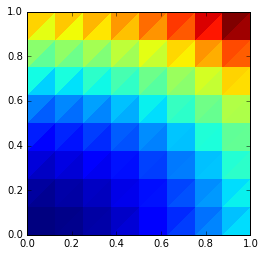

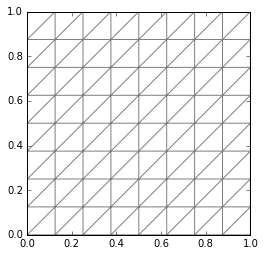

In [3]:
"""
FEniCS tutorial demo program: Poisson equation with Dirichlet conditions.
Test problem is chosen to give an exact solution at all nodes of the mesh.
  -Laplace(u) = f    in the unit square
            u = u_D  on the boundary
  u_D = 1 + x^2 + 2y^2
    f = -6
"""
%matplotlib inline
from __future__ import print_function
from fenics import *
import numpy as np
import matplotlib.pyplot as plt

# Create mesh and define function space
mesh = UnitSquareMesh(8, 8)
V = FunctionSpace(mesh, 'Lagrange', 1) # 'P' = 'Lagrange'
                                       # P1 = linear triangle
# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(-6.0)
a = dot(grad(u), grad(v))*dx
L = f*v*dx

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Plot
f1 = plt.figure()
plot(u)
f2 = plt.figure()
plot(mesh)

# Save solution to file in VTK format
vtkfile = File('poisson/solution.pvd')
vtkfile << u

# Compute error in L2 norm
error_L2 = errornorm(u_D, u, 'L2')

# Compute maximum error at vertices
vertex_values_u_D = u_D.compute_vertex_values(mesh)
vertex_values_u = u.compute_vertex_values(mesh)
error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))

# Print errors
print('error_L2  =', error_L2)
print('error_max =', error_max)


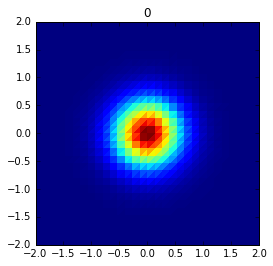

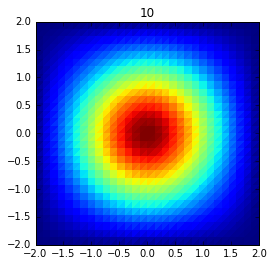

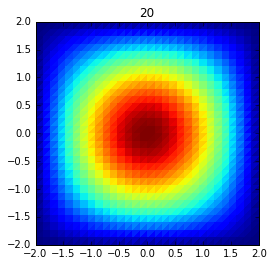

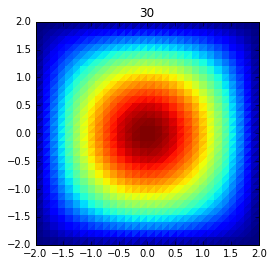

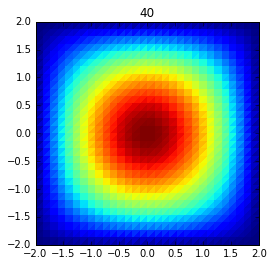

In [4]:
"""
FEniCS tutorial demo program: Heat equation with Dirichlet conditions.
Test problem is chosen to give an exact solution at all nodes of the mesh.
  u'= Laplace(u) + f  in the unit square
  u = u_D             on the boundary
  u = u_0             at t = 0
  u = 1 + x^2 + alpha*y^2 + \beta*t
  f = beta - 2 - 2*alpha
"""
%matplotlib inline
from fenics import *
import time

T = 2.0            # final time
num_steps = 50     # number of time steps
dt = T / num_steps # time step size
alpha = 3          # parameter alpha
beta = 1.2         # parameter beta

# Create mesh and define function space
nx = ny = 30
mesh = RectangleMesh(Point(-2, -2), Point(2, 2), nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, Constant(0), boundary)

# Define initial value
u_0 = Expression('exp(-a*pow(x[0], 2) - a*pow(x[1], 2))', 
                 degree=2, a=5)
u_n = interpolate(u_0, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)

# Time-stepping
u = Function(V)
t = 0

# File to save results
vtkfile = File('heat_gaussian/solution.pvd')

for n in range(num_steps):

    # Update current time
    t += dt

    # Compute solution
    solve(a == L, u, bc)

    # Store and plot solution
    vtkfile << (u, t)
    if n % 10 == 0:
        plt.figure()
        plot(u, title = n)

    # Update previous solution
    u_n.assign(u)


/opt/apps/ossw/applications/fenics-h/hashstore_gcc_6.1/bld/profile/lrxlypylraa3/lib/python2.7/site-packages/dolfin/cpp/la.py:1279: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)
/opt/apps/ossw/applications/fenics-h/hashstore_gcc_6.1/bld/profile/lrxlypylraa3/lib/python2.7/site-packages/dolfin/cpp/la.py:1279: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)


min/max u: -3.87970475137e-06 0.154585383323


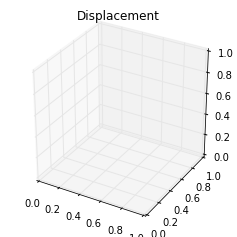

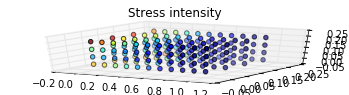

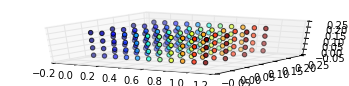

In [3]:
"""
FEniCS tutorial demo program: Linear elastic problem.
  -div(sigma(u)) = f
The model is used to simulate an elastic beam clamped at
its left end and deformed under its own weight.
"""
%matplotlib inline
from __future__ import print_function
from fenics import *
import numpy as np
import matplotlib.pyplot as plt

# Scaled variables
L = 1; W = 0.2
mu = 1
rho = 1
delta = W/L
gamma = 0.4*delta**2
beta = 1.25
lambda_ = beta
g = gamma

# Create mesh and define function space
mesh = BoxMesh(Point(0, 0, 0), Point(L, W, W), 10, 3, 3)
V = VectorFunctionSpace(mesh, 'P', 1)

# Define boundary condition
tol = 1E-14

def clamped_boundary(x, on_boundary):
    return on_boundary and x[0] < tol

bc = DirichletBC(V, Constant((0, 0, 0)), clamped_boundary)

# Define strain and stress

def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    #return sym(nabla_grad(u))

def sigma(u):
    return lambda_*nabla_div(u)*Identity(d) + 2*mu*epsilon(u)

# Define variational problem
u = TrialFunction(V)
d = u.geometric_dimension()  # space dimension
v = TestFunction(V)
f = Constant((0, 0, -rho*g))
T = Constant((0, 0, 0))
a = inner(sigma(u), epsilon(v))*dx
L = dot(f, v)*dx + dot(T, v)*ds

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Plot solution
plt.figure()
plot(u, title='Displacement', mode='displacement')

# Plot stress
s = sigma(u) - (1./3)*tr(sigma(u))*Identity(d)  # deviatoric stress
von_Mises = sqrt(3./2*inner(s, s))
V = FunctionSpace(mesh, 'P', 1)
von_Mises = project(von_Mises, V)
plt.figure()
plot(von_Mises, title='Stress intensity')

# Compute magnitude of displacement
u_magnitude = sqrt(dot(u, u))
u_magnitude = project(u_magnitude, V)
plt.figure()
plot(u_magnitude, 'Displacement magnitude')
print('min/max u:',
      u_magnitude.vector().array().min(),
      u_magnitude.vector().array().max())

# Save solution to file in VTK format
File('elasticity/displacement.pvd') << u
File('elasticity/von_mises.pvd') << von_Mises
File('elasticity/magnitude.pvd') << u_magnitude



In [1]:
"""
FEniCS tutorial demo program: Incompressible Navier-Stokes equations
for flow around a cylinder using the Incremental Pressure Correction
Scheme (IPCS).
  u' + u . nabla(u)) - div(sigma(u, p)) = f
                                 div(u) = 0
"""

from __future__ import print_function
from fenics import *
from mshr import *
import numpy as np

T = 0.1           # final time
num_steps = 100   # number of time steps
dt = T / num_steps # time step size
mu = 0.001         # dynamic viscosity
rho = 1            # density

# Create mesh
channel = Rectangle(Point(0, 0), Point(2.2, 0.41))
cylinder = Circle(Point(0.2, 0.2), 0.05)
domain = channel - cylinder
mesh = generate_mesh(domain, 64)

# Define function spaces
V = VectorFunctionSpace(mesh, 'P', 2)
Q = FunctionSpace(mesh, 'P', 1)

# Define boundaries
inflow   = 'near(x[0], 0)'
outflow  = 'near(x[0], 2.2)'
walls    = 'near(x[1], 0) || near(x[1], 0.41)'
cylinder = 'on_boundary && x[0]>0.1 && x[0]<0.3 && x[1]>0.1 && x[1]<0.3'

# Define inflow profile
inflow_profile = ('4.0*1.5*x[1]*(0.41 - x[1]) / pow(0.41, 2)', '0')

# Define boundary conditions
bcu_inflow = DirichletBC(V, Expression(inflow_profile, degree=2), inflow)
bcu_walls = DirichletBC(V, Constant((0, 0)), walls)
bcu_cylinder = DirichletBC(V, Constant((0, 0)), cylinder)
bcp_outflow = DirichletBC(Q, Constant(0), outflow)
bcu = [bcu_inflow, bcu_walls, bcu_cylinder]
bcp = [bcp_outflow]

# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

# Define functions for solutions at previous and current time steps
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)

# Define expressions used in variational forms
U  = 0.5*(u_n + u)
n  = FacetNormal(mesh)
f  = Constant((0, 0))
k  = Constant(dt)
mu = Constant(mu)
rho = Constant(rho)

# Define symmetric gradient
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))

# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx \
   + rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx

# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

# Create XDMF files for visualization output
xdmffile_u = XDMFFile('navier_stokes_cylinder/velocity.xdmf')
xdmffile_p = XDMFFile('navier_stokes_cylinder/pressure.xdmf')

# Create time series (for use in reaction_system.py)
timeseries_u = TimeSeries('navier_stokes_cylinder/velocity_series')
timeseries_p = TimeSeries('navier_stokes_cylinder/pressure_series')

# Save mesh to file (for use in reaction_system.py)
File('navier_stokes_cylinder/cylinder.xml.gz') << mesh

# Create progress bar
progress = Progress('Time-stepping')
set_log_level(PROGRESS)

# Time-stepping
t = 0
for n in range(num_steps):
    print(n)
    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1, 'bicgstab', 'hypre_amg')

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2, 'bicgstab', 'hypre_amg')

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3, 'cg', 'sor')

    # Plot solution
    plot(u_, title='Velocity')
    plot(p_, title='Pressure')

    # Save solution to file (XDMF/HDF5)
    xdmffile_u.write(u_, t)
    xdmffile_p.write(p_, t)

    # Save nodal values to file
    timeseries_u.store(u_.vector(), t)
    timeseries_p.store(p_.vector(), t)

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)

    # Update progress bar
    progress.update(t / T)
    #print('u max:', u_.vector().array().max())


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [2]:
"""
FEniCS tutorial demo program: Convection-diffusion-reaction for a system
describing the concentration of three species A, B, C undergoing a simple
first-order reaction A + B --> C with first-order decay of C. The velocity
is given by the flow field w from the demo navier_stokes_cylinder.py.
  u_1' + w . nabla(u_1) - div(eps*grad(u_1)) = f_1 - K*u_1*u_2
  u_2' + w . nabla(u_2) - div(eps*grad(u_2)) = f_2 - K*u_1*u_2
  u_3' + w . nabla(u_3) - div(eps*grad(u_3)) = f_3 + K*u_1*u_2 - K*u_3
"""

from __future__ import print_function
from fenics import *

T = 5.0            # final time
num_steps = 500    # number of time steps
dt = T / num_steps # time step size
eps = 0.01         # diffusion coefficient
K = 10.0           # reaction rate

# Read mesh from file
mesh = Mesh('navier_stokes_cylinder/cylinder.xml.gz')

# Define function space for velocity
W = VectorFunctionSpace(mesh, 'P', 2)

# Define function space for system of concentrations
P1 = FiniteElement('P', triangle, 1)
element = MixedElement([P1, P1, P1])
V = FunctionSpace(mesh, element)

# Define test functions
v_1, v_2, v_3 = TestFunctions(V)

# Define functions for velocity and concentrations
w = Function(W)
u = Function(V)
u_n = Function(V)

# Split system functions to access components
u_1, u_2, u_3 = split(u)
u_n1, u_n2, u_n3 = split(u_n)

# Define source terms
f_1 = Expression('pow(x[0]-0.1,2)+pow(x[1]-0.1,2)<0.05*0.05 ? 0.1 : 0',
                 degree=1)
f_2 = Expression('pow(x[0]-0.1,2)+pow(x[1]-0.3,2)<0.05*0.05 ? 0.1 : 0',
                 degree=1)
f_3 = Constant(0)

# Define expressions used in variational forms
k = Constant(dt)
K = Constant(K)
eps = Constant(eps)

# Define variational problem
F = ((u_1 - u_n1) / k)*v_1*dx + dot(w, grad(u_1))*v_1*dx \
  + eps*dot(grad(u_1), grad(v_1))*dx + K*u_1*u_2*v_1*dx  \
  + ((u_2 - u_n2) / k)*v_2*dx + dot(w, grad(u_2))*v_2*dx \
  + eps*dot(grad(u_2), grad(v_2))*dx + K*u_1*u_2*v_2*dx  \
  + ((u_3 - u_n3) / k)*v_3*dx + dot(w, grad(u_3))*v_3*dx \
  + eps*dot(grad(u_3), grad(v_3))*dx - K*u_1*u_2*v_3*dx + K*u_3*v_3*dx \
  - f_1*v_1*dx - f_2*v_2*dx - f_3*v_3*dx

# Create time series for reading velocity data
timeseries_w = TimeSeries('navier_stokes_cylinder/velocity_series')

# Create VTK files for visualization output
vtkfile_u_1 = File('reaction_system/u_1.pvd')
vtkfile_u_2 = File('reaction_system/u_2.pvd')
vtkfile_u_3 = File('reaction_system/u_3.pvd')

# Create progress bar
progress = Progress('Time-stepping')
set_log_level(PROGRESS)

# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Read velocity from file
    timeseries_w.retrieve(w.vector(), t)

    # Solve variational problem for time step
    solve(F == 0, u)

    # Save solution to file (VTK)
    _u_1, _u_2, _u_3 = u.split()
    vtkfile_u_1 << (_u_1, t)
    vtkfile_u_2 << (_u_2, t)
    vtkfile_u_3 << (_u_3, t)

    # Update previous solution
    u_n.assign(u)

    # Update progress bar
    progress.update(t / T)


In [5]:
type(((u_1 - u_n1)))

ufl.algebra.Sum